**Import and Install Required Dependencies**

In [1]:
import numpy as np 
import pandas as pd 
import os
from sklearn.model_selection import train_test_split
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
!pip install bert-tensorflow
import bert
from bert import run_classifier
from bert import optimization
from bert import tokenization

     |████████████████████████████████| 71kB 3.3MB/s 


**Load the Data**

In [2]:
train_vaccine = pd.read_csv('../input/training_data.csv')
test_vaccine = pd.read_csv('../input/to_shuffle_test_data.csv')

train_vaccine = train_vaccine.sample(50000)
test_vaccine = test_vaccine.sample(10000)

**Generate Input Examples from Data**

In [3]:
DATA_COLUMN = 'text'
LABEL_COLUMN = 'target'
# label_list is the list of labels, 0 = not antivax, 1 = antivax
label_list = [0, 1]

# Use the InputExample class from BERT's run_classifier code to create examples from the data
train_InputExamples = train_vaccine.apply(lambda x: bert.run_classifier.InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this example
                                                                   text_a = x[DATA_COLUMN], 
                                                                   text_b = None, 
                                                                   label = x[LABEL_COLUMN]), axis = 1)

test_InputExamples = test_vaccine.apply(lambda x: bert.run_classifier.InputExample(guid=None, 
                                                                   text_a = x[DATA_COLUMN], 
                                                                   text_b = None, 
                                                                   label = x[LABEL_COLUMN]), axis = 1)

**Load the Pre-Trained Bert Model**

In [4]:
# This is a path to an uncased (all lowercase) version of BERT
BERT_MODEL_HUB = "https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1"

def create_tokenizer_from_hub_module():
  """Get the vocab file and casing info from the Hub module."""
  with tf.Graph().as_default():
    bert_module = hub.Module(BERT_MODEL_HUB)
    tokenization_info = bert_module(signature="tokenization_info", as_dict=True)
    with tf.Session() as sess:
      vocab_file, do_lower_case = sess.run([tokenization_info["vocab_file"],
                                            tokenization_info["do_lower_case"]])
      
  return bert.tokenization.FullTokenizer(
      vocab_file=vocab_file, do_lower_case=do_lower_case)

tokenizer = create_tokenizer_from_hub_module()

**Generate Features From Data Using BERT **

In [5]:
# We'll set sequences to be at most 128 tokens long
MAX_SEQ_LENGTH = 128
# Convert our train and test features to InputFeatures that BERT understands.
train_features = bert.run_classifier.convert_examples_to_features(train_InputExamples, label_list, MAX_SEQ_LENGTH, tokenizer)
test_features = bert.run_classifier.convert_examples_to_features(test_InputExamples, label_list, MAX_SEQ_LENGTH, tokenizer)

**Creating The Model for Classification**

In [6]:
def create_model(is_predicting, input_ids, input_mask, segment_ids, labels,
                 num_labels):
  """Creates a classification model."""

  bert_module = hub.Module(
      BERT_MODEL_HUB,
      trainable=True)
  bert_inputs = dict(
      input_ids=input_ids,
      input_mask=input_mask,
      segment_ids=segment_ids)
  bert_outputs = bert_module(
      inputs=bert_inputs,
      signature="tokens",
      as_dict=True)

  # We are using "pooled_output" as we want to classify the entire sentence
  output_layer = bert_outputs["pooled_output"]

  hidden_size = output_layer.shape[-1].value

  # Create our own layer to tune for politeness data.
  output_weights = tf.get_variable(
      "output_weights", [num_labels, hidden_size],
      initializer=tf.truncated_normal_initializer(stddev=0.02))

  output_bias = tf.get_variable(
      "output_bias", [num_labels], initializer=tf.zeros_initializer())

  with tf.variable_scope("loss"):

    # Dropout helps prevent overfitting
    output_layer = tf.nn.dropout(output_layer, keep_prob=0.9)

    logits = tf.matmul(output_layer, output_weights, transpose_b=True)
    logits = tf.nn.bias_add(logits, output_bias)
    log_probs = tf.nn.log_softmax(logits, axis=-1)

    # Convert labels into one-hot encoding
    one_hot_labels = tf.one_hot(labels, depth=num_labels, dtype=tf.float32)

    predicted_labels = tf.squeeze(tf.argmax(log_probs, axis=-1, output_type=tf.int32))
    # If we're predicting, we want predicted labels and the probabiltiies.
    if is_predicting:
      return (predicted_labels, log_probs)

    # If we're training or evaluating, compute loss between predicted and actual label
    per_example_loss = -tf.reduce_sum(one_hot_labels * log_probs, axis=-1)
    loss = tf.reduce_mean(per_example_loss)
    return (loss, predicted_labels, log_probs)

In [7]:
def model_fn_builder(num_labels, learning_rate, num_train_steps,
                     num_warmup_steps):
  """Returns `model_fn` closure for TPUEstimator."""
  def model_fn(features, labels, mode, params):  # pylint: disable=unused-argument
    """The `model_fn` for TPUEstimator."""

    input_ids = features["input_ids"]
    input_mask = features["input_mask"]
    segment_ids = features["segment_ids"]
    label_ids = features["label_ids"]

    is_predicting = (mode == tf.estimator.ModeKeys.PREDICT)
    
    # TRAIN and EVAL
    if not is_predicting:

      (loss, predicted_labels, log_probs) = create_model(
        is_predicting, input_ids, input_mask, segment_ids, label_ids, num_labels)

      train_op = bert.optimization.create_optimizer(
          loss, learning_rate, num_train_steps, num_warmup_steps, use_tpu=False)

      # Calculate evaluation metrics. 
      def metric_fn(label_ids, predicted_labels):
        accuracy = tf.metrics.accuracy(label_ids, predicted_labels)
        f1_score = tf.contrib.metrics.f1_score(
            label_ids,
            predicted_labels)
        auc = tf.metrics.auc(
            label_ids,
            predicted_labels)
        recall = tf.metrics.recall(
            label_ids,
            predicted_labels)
        precision = tf.metrics.precision(
            label_ids,
            predicted_labels) 
        true_pos = tf.metrics.true_positives(
            label_ids,
            predicted_labels)
        true_neg = tf.metrics.true_negatives(
            label_ids,
            predicted_labels)   
        false_pos = tf.metrics.false_positives(
            label_ids,
            predicted_labels)  
        false_neg = tf.metrics.false_negatives(
            label_ids,
            predicted_labels)
        return {
            "eval_accuracy": accuracy,
            "f1_score": f1_score,
            "auc": auc,
            "precision": precision,
            "recall": recall,
            "true_positives": true_pos,
            "true_negatives": true_neg,
            "false_positives": false_pos,
            "false_negatives": false_neg
        }

      eval_metrics = metric_fn(label_ids, predicted_labels)

      if mode == tf.estimator.ModeKeys.TRAIN:
        return tf.estimator.EstimatorSpec(mode=mode,
          loss=loss,
          train_op=train_op)
      else:
          return tf.estimator.EstimatorSpec(mode=mode,
            loss=loss,
            eval_metric_ops=eval_metrics)
    else:
      (predicted_labels, log_probs) = create_model(
        is_predicting, input_ids, input_mask, segment_ids, label_ids, num_labels)

      predictions = {
          'probabilities': log_probs,
          'labels': predicted_labels
      }
      return tf.estimator.EstimatorSpec(mode, predictions=predictions)

  # Return the actual model function in the closure
  return model_fn

**Model Hyperparameters**

In [8]:
# Compute train and warmup steps from batch size
# These hyperparameters are copied from this colab notebook (https://colab.sandbox.google.com/github/tensorflow/tpu/blob/master/tools/colab/bert_finetuning_with_cloud_tpus.ipynb)
BATCH_SIZE = 32 
LEARNING_RATE = 2e-5
NUM_TRAIN_EPOCHS = 2.0 
WARMUP_PROPORTION = 0.1
# Model configs
SAVE_CHECKPOINTS_STEPS = 500
SAVE_SUMMARY_STEPS = 100

num_train_steps = int(len(train_features) / BATCH_SIZE * NUM_TRAIN_EPOCHS)
num_warmup_steps = int(num_train_steps * WARMUP_PROPORTION)

**Specify Output Directory**

In [9]:
OUTPUT_DIR = '../test_output/'
run_config = tf.estimator.RunConfig(
    model_dir=OUTPUT_DIR,
    save_summary_steps=SAVE_SUMMARY_STEPS,
    save_checkpoints_steps=SAVE_CHECKPOINTS_STEPS)

**Create Instances of Model and Estimator**

In [10]:
model_fn = model_fn_builder(
  num_labels=len(label_list),
  learning_rate=LEARNING_RATE,
  num_train_steps=num_train_steps,
  num_warmup_steps=num_warmup_steps)

estimator = tf.estimator.Estimator(
  model_fn=model_fn,
  config=run_config,
  params={"batch_size": BATCH_SIZE})

In [11]:
import datetime
# Create an input function for training. drop_remainder = True for using TPUs.
train_input_fn = bert.run_classifier.input_fn_builder(
    features=train_features,
    seq_length=MAX_SEQ_LENGTH,
    is_training=True,
    drop_remainder=False)

**Train the Model**

In [12]:
print(f'Beginning Training!')
current_time = datetime.datetime.now()
estimator.train(input_fn=train_input_fn, max_steps=num_train_steps)
print("Training took time ", datetime.datetime.now() - current_time)

Beginning Training!


/opt/conda/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "



For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Training took time  0:26:35.235075


**Evaluate Model**

In [13]:
test_input_fn = run_classifier.input_fn_builder(
    features=test_features,
    seq_length=MAX_SEQ_LENGTH,
    is_training=False,
    drop_remainder=False)

estimator.evaluate(input_fn=test_input_fn, steps=None)

/opt/conda/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


{'auc': 0.9275549,
 'eval_accuracy': 0.9281,
 'f1_score': 0.9220596,
 'false_negatives': 368.0,
 'false_positives': 351.0,
 'loss': 0.23143005,
 'precision': 0.92376196,
 'recall': 0.92036355,
 'true_negatives': 5028.0,
 'true_positives': 4253.0,
 'global_step': 3125}

**Helper Function to Return Predictions on New Comments**

In [14]:
def getPrediction(in_sentences):
  labels = ["Not antivax (0)", "Antivax (1)"]
  input_examples = [run_classifier.InputExample(guid="", text_a = x, text_b = None, label = 0) for x in in_sentences] # here, "" is just a dummy label
  input_features = run_classifier.convert_examples_to_features(input_examples, label_list, MAX_SEQ_LENGTH, tokenizer)
  predict_input_fn = run_classifier.input_fn_builder(features=input_features, seq_length=MAX_SEQ_LENGTH, is_training=False, drop_remainder=False)
  predictions = estimator.predict(predict_input_fn)
  return [(sentence, prediction['probabilities'], labels[prediction['labels']]) for sentence, prediction in zip(in_sentences, predictions)]

**Example Sentences For Model To Predict On**

In [15]:
pred_sentences = [
  "vaccines are bad they kill kids and are a harm to society",
  "If you don’t vaccinate your children, you’re putting my children in danger.",
  "My child doesn’t need vaccines because no one gets these diseases anymore", "Vaccines work",
    "so nasty You don t get your own facts It s delusional to believe that vaccines are unnecessary", "Vaccines are good"
    "I have a similar wish to Ginger. Id like to be able to put books into more than one collection. eg - Jane Eyre would be in Classic Novels, and Favourites",
    "It is my strange addiction! I cant put it down",
]

In [16]:
predictions = getPrediction(pred_sentences)
predictions

[('vaccines are bad they kill kids and are a harm to society',
  array([-5.8329754e+00, -2.9336058e-03], dtype=float32),
  'Antivax (1)'),
 ('If you don’t vaccinate your children, you’re putting my children in danger.',
  array([-6.343380e+00, -1.759887e-03], dtype=float32),
  'Antivax (1)'),
 ('My child doesn’t need vaccines because no one gets these diseases anymore',
  array([-0.3575521, -1.2019293], dtype=float32),
  'Not antivax (0)'),
 ('Vaccines work',
  array([-4.7731752 , -0.00848947], dtype=float32),
  'Antivax (1)'),
 ('so nasty You don t get your own facts It s delusional to believe that vaccines are unnecessary',
  array([-6.8743286e+00, -1.0345589e-03], dtype=float32),
  'Antivax (1)'),
 ('Vaccines are goodI have a similar wish to Ginger. Id like to be able to put books into more than one collection. eg - Jane Eyre would be in Classic Novels, and Favourites',
  array([-5.6926656e+00, -3.3762616e-03], dtype=float32),
  'Antivax (1)'),
 ('It is my strange addiction! I cant 

**Confusion Matrix**

In [17]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

In [18]:
# with one evaluator example
matrix = np.zeros((2,2))
#true neg
matrix[0][0] = 5044 
#false neg
matrix[1][0] = 351
#true pos
matrix[1][1] = 4257 
#false pos
matrix[0][1] = 348

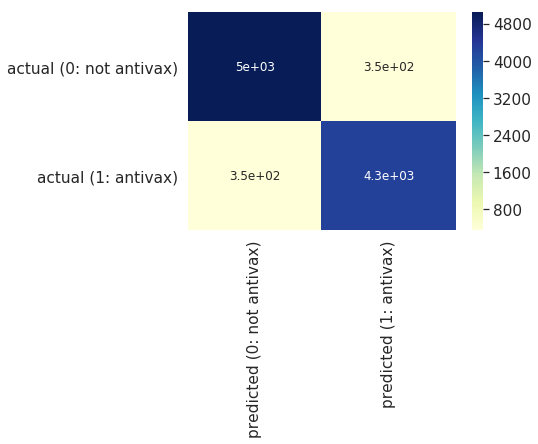

In [19]:
df_cm = pd.DataFrame(matrix, range(2),
                  range(2))
df_cm.columns = ['predicted (0: not antivax)', 'predicted (1: antivax)']
df_cm.index = ['actual (0: not antivax)', 'actual (1: antivax)']

df_cm
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 12}, cmap="YlGnBu")# font size

**Predicting on Tweets**

Install and Import Required Dependencies

In [20]:
!pip install tweepy
!pip install --upgrade pip
!pip install textblob
!python -m textblob.download_corpora

     |████████████████████████████████| 143kB 9.7MB/s 
Requirement already up-to-date: pip in /opt/conda/lib/python3.6/site-packages (19.1.1)
[nltk_data] Downloading package brown to /usr/share/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package conll2000 to /usr/share/nltk_data...
[nltk_data]   Package conll2000 is already up-to-date!
[nltk_data] Downloading package movie_reviews to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
Finished.


In [21]:
import re
import tweepy
from tweepy import OAuthHandler
from textblob import TextBlob

In [22]:
class TwitterClient(object):
    def __init__(self): 
        consumer_key = 'iDvGwmjxPebcaqVK6USXRU4Mf'
        consumer_secret = 'qu3dGTeP7F537RCCBVjASp9FF4nzSHE0mPTPfzfdFqQ7IFu66y'
        access_token = '401084368-TXjrqQnYd7DFLW1ulz37dMijJgwSslSMIRT6pDzz'
        access_token_secret = 'XQVuwTpQCEKy0KwxTN61Cq72NrT1ihKbxm84poTFAcm5E'
        
        try:
            self.auth = OAuthHandler(consumer_key, consumer_secret)
            self.auth.set_access_token(access_token, access_token_secret)
            self.api = tweepy.API(self.auth)
        except:
            print("Error: Authentication Failed")
            
    def clean_tweet(self, tweet):
        return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet).split()) 
    
    def get_tweets(self, query, count = 10):
        tweets = []
        
        try:
            fetched_tweets = self.api.search(q = query, count = count)
            
            for tweet in fetched_tweets:
                
                tweets.append(self.clean_tweet(tweet.text))
                
            return tweets
        
        except tweepy.TweepError as e:
            print("error :" + str(e))